The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Classificação de Imagens (CIFAR-10) no Kaggle
:label:`sec_kaggle_cifar10`


Até agora, temos usado o pacote `data` do Gluon para obter diretamente conjuntos de dados de imagem no formato tensor. Na prática, entretanto, os conjuntos de dados de imagem geralmente existem no formato de arquivos de imagem. Nesta seção, começaremos com os arquivos de imagem originais e organizaremos, leremos e converteremos os arquivos para o formato tensor passo a passo.

Realizamos um experimento no conjunto de dados CIFAR-10 em :numref:`sec_image_augmentation`.
Este é um dado importante
definido no campo de visão do computador. Agora, vamos aplicar o conhecimento que aprendemos em
as seções anteriores para participar da competição Kaggle, que
aborda problemas de classificação de imagens CIFAR-10. O endereço da competição na web
é

> https://www.kaggle.com/c/cifar-10

:numref:`fig_kaggle_cifar10` mostra as informações na página da competição. Para enviar os resultados, primeiro registre uma conta no site do Kaggle.

![Informações da página da web do concurso de classificação de imagens CIFAR-10. O conjunto de dados da competição pode ser acessado clicando na guia "Dados".](../img/kaggle-cifar10.png)
:width:`600px`
:label:`fig_kaggle_cifar10`

Primeiro, importe os pacotes ou módulos necessários para a competição.


In [1]:
import collections
import math
import os
import shutil
import pandas as pd
from mxnet import gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Obtendo e Organizando o *Dataset*

Os dados da competição são divididos em um conjunto de treinamento e um conjunto de teste. O conjunto de treinamento contém $50.000$ imagens. O conjunto de teste contém $300.000$ imagens, das quais $10.000$ imagens são usadas para pontuação, enquanto as outras $290.000$ imagens sem pontuação são incluídas para evitar a rotulagem manual do conjunto de teste e o envio dos resultados da rotulagem. Os formatos de imagem em ambos os conjuntos de dados são PNG, com alturas e larguras de 32 pixels e três canais de cores (RGB). As imagens cobrem categorias de $10$: aviões, carros, pássaros, gatos, veados, cães, sapos, cavalos, barcos e caminhões. O canto superior esquerdo de :numref:`fig_kaggle_cifar10` mostra algumas imagens de aviões, carros e pássaros no conjunto de dados.

### Baixando o Dataset

Após fazer o login no Kaggle, podemos clicar na guia "Dados" na página da competição de classificação de imagens CIFAR-10 mostrada em :numref:`fig_kaggle_cifar10` e baixar o conjunto de dados clicando no botão "*Download All*". Após descompactar o arquivo baixado em `../data` e descompactar `train.7z` e `test.7z` dentro dele, você encontrará o conjunto de dados inteiro nos seguintes caminhos:

* ../data/cifar-10/train/[1-50000].png
* ../data/cifar-10/test/[1-300000].png
* ../data/cifar-10/trainLabels.csv
* ../data/cifar-10/sampleSubmission.csv


Aqui, as pastas `train` e` test` contêm as imagens de treinamento e teste, respectivamente, `trainLabels.csv` tem rótulos para as imagens de treinamento e `sample_submission.csv` é um exemplo de envio.

Para facilitar o início, fornecemos uma amostra em pequena escala do conjunto de dados: ele contém as primeiras $1000$ de imagens de treinamento e $5$ de imagens de teste aleatórias.
Para usar o conjunto de dados completo da competição Kaggle, você precisa definir a seguinte variável `demo` como `False`.


In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### Organizando o Dataset

Precisamos organizar conjuntos de dados para facilitar o treinamento e teste do modelo. Vamos primeiro ler os rótulos do arquivo csv. A função a seguir retorna um dicionário que mapeia o nome do arquivo sem extensão para seu rótulo.


In [3]:
#@save
def read_csv_labels(fname):
    """Read fname to return a name to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


Em seguida, definimos a função `reorg_train_valid` para segmentar o conjunto de validação do conjunto de treinamento original. O argumento `valid_ratio` nesta função é a razão entre o número de exemplos no conjunto de validação e o número de exemplos no conjunto de treinamento original. Em particular, seja $n$ o número de imagens da classe com menos exemplos e $r$ a proporção, então usaremos $\max(\lfloor nr\rfloor,1)$ imagens para cada classe como o conjunto de validação. Vamos usar `valid_ratio = 0.1` como exemplo. Como o conjunto de treinamento original tem $50.000$ imagens, haverá $45.000$ imagens usadas para treinamento e armazenadas no caminho "`train_valid_test/train`" ao ajustar hiperparâmetros, enquanto as outras $5.000$ imagens serão armazenadas como conjunto de validação no caminho "`train_valid_test / valid`". Depois de organizar os dados, as imagens da mesma turma serão colocadas na mesma pasta para que possamos lê-las posteriormente.


In [4]:
#@save
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    # The number of examples of the class with the least examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        # Copy to train_valid_test/train_valid with a subfolder per class
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            # Copy to train_valid_test/valid
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # Copy to train_valid_test/train
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

A função `reorg_test` abaixo é usada para organizar o conjunto de testes para facilitar a leitura durante a previsão.


In [5]:
#@save
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

Finalmente, usamos uma função para chamar as funções `read_csv_labels`, `reorg_train_valid` e `reorg_test` previamente definidas.


In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

Definimos apenas o tamanho do lote em $4$ para o conjunto de dados de demonstração. Durante o treinamento e os testes reais, o conjunto de dados completo da competição Kaggle deve ser usado e `batch_size` deve ser definido como um número inteiro maior, como $128$. Usamos $10\%$ dos exemplos de treinamento como o conjunto de validação para ajustar os hiperparâmetros.


In [7]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## Aumento de Imagem

Para lidar com o *overfitting*, usamos o aumento da imagem. Por exemplo, adicionando `transforms.RandomFlipLeftRight()`, as imagens podem ser invertidas aleatoriamente. Também podemos realizar a normalização para os três canais RGB de imagens coloridas usando `transforma.Normalize()`. Abaixo, listamos algumas dessas operações que você pode escolher para usar ou modificar, dependendo dos requisitos.


In [8]:
transform_train = gluon.data.vision.transforms.Compose([
    # Magnify the image to a square of 40 pixels in both height and width
    gluon.data.vision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then shrink it to a square of 32 pixels in both height and
    # width
    gluon.data.vision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    # Normalize each channel of the image
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

Para garantir a certeza da saída durante o teste, realizamos apenas normalização na imagem.


In [9]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

## Lendo o *Dataset*

Em seguida, podemos criar a instância `ImageFolderDataset` para ler o conjunto de dados organizado contendo os arquivos de imagem originais, onde cada exemplo inclui a imagem e o rótulo.


In [10]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ['train', 'valid', 'train_valid', 'test']]

Especificamos a operação de aumento de imagem definida em `DataLoader`. Durante o treinamento, usamos apenas o conjunto de validação para avaliar o modelo, portanto, precisamos garantir a certeza do resultado. Durante a previsão, treinaremos o modelo no conjunto de treinamento combinado e no conjunto de validação para fazer uso completo de todos os dados rotulados.


In [11]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True,
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='keep')

## Definindo o Modelo

Aqui, construímos os blocos residuais com base na classe `HybridBlock`, que é ligeiramente diferente da implementação descrita em :numref:`sec_resnet`. Isso é feito para melhorar a eficiência de execução.


In [12]:
class Residual(nn.HybridBlock):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def hybrid_forward(self, F, X):
        Y = F.npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.npx.relu(Y + X)

A seguir, definimos o modelo ResNet-18.


In [13]:
def resnet18(num_classes):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))

    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.HybridSequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

O desafio de classificação de imagens CIFAR-10 usa 10 categorias. Vamos realizar a inicialização aleatória de Xavier no modelo antes do início do treinamento.


In [14]:
def get_net(devices):
    num_classes = 10
    net = resnet18(num_classes)
    net.initialize(ctx=devices, init=init.Xavier())
    return net

loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Definindo as Funções de Treinamento

Selecionaremos o modelo e ajustaremos os hiperparâmetros de acordo com o desempenho do modelo no conjunto de validação. Em seguida, definimos a função de treinamento do modelo `treinar`. Registramos o tempo de treinamento de cada época, o que nos ajuda a comparar os custos de tempo de diferentes modelos.


In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels.astype('float32'), loss, trainer,
                devices, d2l.split_batch)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpus(net, valid_iter,
                                                   d2l.split_batch)
            animator.add(epoch + 1, (None, None, valid_acc))
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Treinamento e Validação do Modelo

Agora podemos treinar e validar o modelo. Os hiperparâmetros a seguir podem ser ajustados. Por exemplo, podemos aumentar o número de épocas. Como `lr_period` e` lr_decay` são definidos como 50 e 0,1 respectivamente, a taxa de aprendizado do algoritmo de otimização será multiplicada por 0,1 a cada 50 épocas. Para simplificar, treinamos apenas uma época aqui.


loss nan, train acc 0.102, valid acc 0.100
131.6 examples/sec on [gpu(0), gpu(1)]


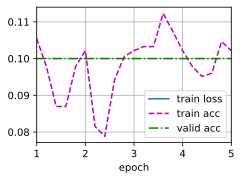

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classificando o Conjunto de Testes e Enviando Resultados no Kaggle

Depois de obter um design de modelo satisfatório e hiperparâmetros, usamos todos os conjuntos de dados de treinamento (incluindo conjuntos de validação) para treinar novamente o modelo e classificar o conjunto de teste.


loss nan, train acc 0.102
138.0 examples/sec on [gpu(0), gpu(1)]


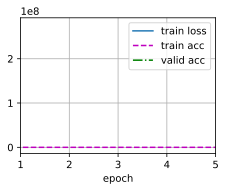

In [17]:
net, preds = get_net(devices), []
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.as_in_ctx(devices[0]))
    preds.extend(y_hat.argmax(axis=1).astype(int).asnumpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

Após executar o código acima, obteremos um arquivo "submit.csv". O formato deste arquivo é consistente com os requisitos da competição Kaggle. O método para enviar resultados é semelhante ao método em :numref:`sec_kaggle_house`.

## Resumo

* Podemos criar uma instância `ImageFolderDataset` para ler o conjunto de dados contendo os arquivos de imagem originais.
* Podemos usar redes neurais convolucionais, aumento de imagens e programação híbrida para participar de uma competição de classificação de imagens.

## Exercícios

1. Use o conjunto de dados CIFAR-10 completo para a competição Kaggle. Altere o `batch_size` e o número de épocas `num_epochs` para 128 e 100, respectivamente. Veja qual precisão e classificação você pode alcançar nesta competição.
1. Que precisão você pode alcançar quando não está usando o aumento de imagem?
1. Digitalize o código QR para acessar as discussões relevantes e trocar ideias sobre os métodos usados e os resultados obtidos com a comunidade. Você pode sugerir técnicas melhores?


[Discussões](https://discuss.d2l.ai/t/379)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMjE0NzI1MTc5NiwtMTgzMDA3NDczMywtNz
M4OTY5ODQ5LC0xODAxMjg4MTU2LC0xODM2MTgwNzY3LC01NTc3
OTc3MTldfQ==
-->
